# Recognizing Human Activities using Smartphones
## Classification on Human Activity Recognition Using Smartphones Data Set

### Introduction

Human Activity Recognition (HAR) determines the activity done by an individual based on their surroundings and observations. Smartphones are powerful sensing tools used to accomplish HAR. Embedded built-in sensors such as microphones, accelerometers and gyroscopes are typical features of modern smartphones.

In 2013, researchers from the University of Genova and Polytechnic University of Catalonia released a public dataset on HAR (Davide et al.). Thirty volunteers between the ages of 19 to 48 wore a Samsung Galaxy X II around the waist. The smartphone accelerometer and gyroscope identified six different human activities: three dynamic activities (1- walking, 2- walking upstairs, 3- walking downstairs) and three static postures (4- sitting, 5- standing, 6- laying). They collected triaxial linear acceleration and angular velocity signals using the phone embedded accelerometer and gyroscope at a constant rate of 50Hz. Noise filters were applied to pre-process the sensor signals. 

Dataset attributes include: 
- Triaxial acceleration obtained from the accelerometer and the estimated body acceleration
- Triaxial angular velocity obtained from the gyroscope
- A 561-feature vector with time and frequency domain variables
- Its activity label 
- A subject identifier of who participated in the experiment 

Group 006-5 will explore this dataset to see if a human activity can be predicted based on the estimated body acceleration and angular velocity. Early works in HAR used the accelerometer to validate its capabilities against behaviour observation (Foerster, Smeja and Fahrenberg 571-583). The results showed that accelerometry is highly reliable for detecting posture and motion. Due to technological advancements, gyroscopes in conjunction with accelerators are becoming more common to use in HAR (Ahmed et al.). Based on these findings, features related to body acceleration and angular velocity are chosen for our analysis.


### Preliminary Exploratory Data Analysis & Methods

In [111]:
# First, we will load required packages
library(repr)
library(knitr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

# Then, set the seed
set.seed(1)

#### I. Demonstrate that the dataset can be read from the web into R

In [112]:
# Data source: http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions#
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"

# Specifying destination where file should be saved
destfile <- "data/localfile.zip"

# Apply download.file function 
download.file(url, destfile)

# unzip the downloaded file
unzip ("data/localfile.zip", exdir = "data/")

#### II. Clean and wrangle data into a tidy format

In [113]:
# create a vector of features to use for col names of training set
# X1 represents the row number
# X2 is the features
features_table <- read_delim("data/UCI HAR Dataset/features.txt", delim = " ", col_names = FALSE)
glimpse(features_table)
features_vector <- dplyr::pull(features_table, 'X2')
features_vector_sub <- gsub("-", "_", features_vector)

features_vector_sub <- gsub("[()]", "", features_vector_sub)
glimpse(features_vector_sub)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_character()
)



Rows: 561
Columns: 2
$ X1 <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,…
$ X2 <chr> "tBodyAcc-mean()-X", "tBodyAcc-mean()-Y", "tBodyAcc-mean()-Z", "tB…
 chr [1:561] "tBodyAcc_mean_X" "tBodyAcc_mean_Y" "tBodyAcc_mean_Z" ...


In [114]:
# create a table of activity labels to add such a variable as a column into the training set data frame.
label_col_name_vec <- c('activity_label')
y_training_label <- read_delim("data/UCI HAR Dataset/train/y_train.txt", delim = " ", col_names = label_col_name_vec) 

y_testing_label <- read_delim("data/UCI HAR Dataset/test/y_test.txt", delim = " ", col_names = label_col_name_vec) 

Parsed with column specification:
cols(
  activity_label = col_double()
)

Parsed with column specification:
cols(
  activity_label = col_double()
)



In [115]:
# read feature values 
x_training_data <- read_delim("data/UCI HAR Dataset/train/X_train.txt", delim = " ", col_names = features_vector_sub)

x_testing_data <- read_delim("data/UCI HAR Dataset/test/X_test.txt", delim = " ", col_names = features_vector_sub)

Warning message:
“Duplicated column names deduplicated: 'fBodyAcc_bandsEnergy_1,8' => 'fBodyAcc_bandsEnergy_1,8_1' [317], 'fBodyAcc_bandsEnergy_9,16' => 'fBodyAcc_bandsEnergy_9,16_1' [318], 'fBodyAcc_bandsEnergy_17,24' => 'fBodyAcc_bandsEnergy_17,24_1' [319], 'fBodyAcc_bandsEnergy_25,32' => 'fBodyAcc_bandsEnergy_25,32_1' [320], 'fBodyAcc_bandsEnergy_33,40' => 'fBodyAcc_bandsEnergy_33,40_1' [321], 'fBodyAcc_bandsEnergy_41,48' => 'fBodyAcc_bandsEnergy_41,48_1' [322], 'fBodyAcc_bandsEnergy_49,56' => 'fBodyAcc_bandsEnergy_49,56_1' [323], 'fBodyAcc_bandsEnergy_57,64' => 'fBodyAcc_bandsEnergy_57,64_1' [324], 'fBodyAcc_bandsEnergy_1,16' => 'fBodyAcc_bandsEnergy_1,16_1' [325], 'fBodyAcc_bandsEnergy_17,32' => 'fBodyAcc_bandsEnergy_17,32_1' [326], 'fBodyAcc_bandsEnergy_33,48' => 'fBodyAcc_bandsEnergy_33,48_1' [327], 'fBodyAcc_bandsEnergy_49,64' => 'fBodyAcc_bandsEnergy_49,64_1' [328], 'fBodyAcc_bandsEnergy_1,24' => 'fBodyAcc_bandsEnergy_1,24_1' [329], 'fBodyAcc_bandsEnergy_25,48' => 'fBodyAcc_ba

In [116]:
# add activity label column to data
training_set_all <- bind_cols(x_training_data, y_training_label)
tail(training_set_all)

testing_set_all <- bind_cols(x_testing_data, y_testing_label)
tail(testing_set_all)

tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,⋯,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,"angletBodyAccMean,gravity","angletBodyAccJerkMean,gravityMean","angletBodyGyroMean,gravityMean","angletBodyGyroJerkMean,gravityMean","angleX,gravityMean","angleY,gravityMean","angleZ,gravityMean",activity_label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
2.3796648e-001,-1.0878070e-003,-1.4832590e-001,-2.1894876e-001,-1.2926748e-002,1.7001874e-001,-3.0959929e-001,-4.1392263e-002,2.0745436e-001,2.1079544e-001,⋯,-5.9248831e-001,-8.6723607e-001,3.5277575e-001,-6.0481685e-001,-7.7478312e-001,7.3014246e-001,-7.9727183e-001,2.3499575e-001,4.8907023e-002,2
2.9966534e-001,-5.7193414e-002,-1.8123302e-001,-1.9538652e-001,3.9904850e-002,7.7078081e-002,-2.8230064e-001,4.3615631e-002,6.0410083e-002,2.1079544e-001,⋯,-5.8843274e-001,-8.8032443e-001,-1.9043686e-001,8.2971842e-001,2.0697215e-001,-4.2561858e-001,-7.9188305e-001,2.3860439e-001,4.9819139e-002,2
2.7385271e-001,-7.7493259e-003,-1.4746837e-001,-2.3530853e-001,4.8162805e-003,5.9279994e-002,-3.2255234e-001,-2.9456250e-002,8.0585116e-002,1.1744028e-001,⋯,-3.9073832e-001,-6.8074445e-001,6.4906712e-002,8.7567905e-001,-8.7903279e-001,4.0021936e-001,-7.7183960e-001,2.5267595e-001,5.0052558e-002,2
2.7338737e-001,-1.7010616e-002,-4.5021828e-002,-2.1821818e-001,-1.0382198e-001,2.7453270e-001,-3.0451515e-001,-9.8913034e-002,3.3258449e-001,4.3998772e-002,⋯,2.5145333e-002,-3.0402936e-001,5.2805928e-002,-2.6672437e-001,8.6440401e-001,7.0116882e-001,-7.7913261e-001,2.4914484e-001,4.0811188e-002,2
2.8965416e-001,-1.8843044e-002,-1.5828059e-001,-2.1913944e-001,-1.1141169e-001,2.6889320e-001,-3.1048749e-001,-6.8200325e-002,3.1947326e-001,1.0170184e-001,⋯,6.3906883e-002,-3.4431361e-001,-1.0136012e-001,7.0073969e-001,9.3667394e-001,-5.8947895e-001,-7.8518142e-001,2.4643223e-001,2.5339478e-002,2
3.5150347e-001,-1.2423118e-002,-2.0386717e-001,-2.6927044e-001,-8.7211541e-002,1.7740393e-001,-3.7740405e-001,-3.8678063e-002,2.2942952e-001,2.6901269e-001,⋯,-3.8705200e-001,-7.4073820e-001,-2.8008805e-001,-7.7392783e-003,-5.6087594e-002,-6.1695645e-001,-7.8326693e-001,2.4680852e-001,3.6694843e-002,2


tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,⋯,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,"angletBodyAccMean,gravity","angletBodyAccJerkMean,gravityMean","angletBodyGyroMean,gravityMean","angletBodyGyroJerkMean,gravityMean","angleX,gravityMean","angleY,gravityMean","angleZ,gravityMean",activity_label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1.9227459e-001,-3.3642566e-002,-1.0594911e-001,-3.5484079e-001,-9.2504346e-002,-3.1290968e-001,-4.3357927e-001,-8.8741465e-002,-3.3605968e-001,-4.1623509e-002,⋯,-6.2965677e-001,-9.1649344e-001,5.3598268e-001,6.8930613e-001,-9.3660649e-001,5.6237487e-001,-6.4675433e-001,2.8215019e-001,1.8115158e-001,2
3.1015462e-001,-5.3391250e-002,-9.9108716e-002,-2.8786635e-001,-1.4058918e-001,-2.1508773e-001,-3.5608315e-001,-1.4877483e-001,-2.3205733e-001,1.8536146e-001,⋯,-3.7627777e-001,-7.5080906e-001,-3.3742157e-001,3.4629489e-001,8.8490383e-001,-6.9888508e-001,-6.5173235e-001,2.7462678e-001,1.8478430e-001,2
3.6338465e-001,-3.9214016e-002,-1.0591509e-001,-3.0538795e-001,2.8147742e-002,-1.9637291e-001,-3.7353982e-001,-3.0036042e-002,-2.7023668e-001,1.8536146e-001,⋯,-3.2041786e-001,-7.0027424e-001,-7.3670095e-001,-3.7288894e-001,-6.5742051e-001,3.2254850e-001,-6.5518092e-001,2.7357825e-001,1.8241215e-001,2
3.4996609e-001,3.0077442e-002,-1.1578796e-001,-3.2963808e-001,-4.2142894e-002,-2.5018068e-001,-3.8801695e-001,-1.3325698e-001,-3.4702897e-001,7.4714557e-003,⋯,-1.1885353e-001,-4.6717918e-001,-1.8156041e-001,8.8574068e-002,6.9666350e-001,3.6313871e-001,-6.5535684e-001,2.7447878e-001,1.8118355e-001,2
2.3759383e-001,1.8466870e-002,-9.6498932e-002,-3.2311431e-001,-2.2977539e-001,-2.0757363e-001,-3.9238016e-001,-2.7961019e-001,-2.8947740e-001,7.4714557e-003,⋯,-2.0544513e-001,-6.1773651e-001,4.4455767e-001,-8.1918771e-001,9.2929414e-001,-8.3982494e-003,-6.5971859e-001,2.6478161e-001,1.8756291e-001,2
1.5362719e-001,-1.8436506e-002,-1.3701846e-001,-3.3004597e-001,-1.9525335e-001,-1.6433879e-001,-4.3097381e-001,-2.1829465e-001,-2.2993287e-001,-1.1152697e-001,⋯,-7.2237101e-002,-4.3694001e-001,5.9880823e-001,-2.8795067e-001,8.7602991e-001,-2.4965139e-002,-6.6008023e-001,2.6393619e-001,1.8810340e-001,2


In [117]:
# combine all the data into one
bothdfs <- rbind(training_set_all, testing_set_all) %>%
      mutate(activity_label = as_factor(activity_label)) 
tail(bothdfs)

tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,⋯,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,"angletBodyAccMean,gravity","angletBodyAccJerkMean,gravityMean","angletBodyGyroMean,gravityMean","angletBodyGyroJerkMean,gravityMean","angleX,gravityMean","angleY,gravityMean","angleZ,gravityMean",activity_label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>
1.9227459e-001,-3.3642566e-002,-1.0594911e-001,-3.5484079e-001,-9.2504346e-002,-3.1290968e-001,-4.3357927e-001,-8.8741465e-002,-3.3605968e-001,-4.1623509e-002,⋯,-6.2965677e-001,-9.1649344e-001,5.3598268e-001,6.8930613e-001,-9.3660649e-001,5.6237487e-001,-6.4675433e-001,2.8215019e-001,1.8115158e-001,2
3.1015462e-001,-5.3391250e-002,-9.9108716e-002,-2.8786635e-001,-1.4058918e-001,-2.1508773e-001,-3.5608315e-001,-1.4877483e-001,-2.3205733e-001,1.8536146e-001,⋯,-3.7627777e-001,-7.5080906e-001,-3.3742157e-001,3.4629489e-001,8.8490383e-001,-6.9888508e-001,-6.5173235e-001,2.7462678e-001,1.8478430e-001,2
3.6338465e-001,-3.9214016e-002,-1.0591509e-001,-3.0538795e-001,2.8147742e-002,-1.9637291e-001,-3.7353982e-001,-3.0036042e-002,-2.7023668e-001,1.8536146e-001,⋯,-3.2041786e-001,-7.0027424e-001,-7.3670095e-001,-3.7288894e-001,-6.5742051e-001,3.2254850e-001,-6.5518092e-001,2.7357825e-001,1.8241215e-001,2
3.4996609e-001,3.0077442e-002,-1.1578796e-001,-3.2963808e-001,-4.2142894e-002,-2.5018068e-001,-3.8801695e-001,-1.3325698e-001,-3.4702897e-001,7.4714557e-003,⋯,-1.1885353e-001,-4.6717918e-001,-1.8156041e-001,8.8574068e-002,6.9666350e-001,3.6313871e-001,-6.5535684e-001,2.7447878e-001,1.8118355e-001,2
2.3759383e-001,1.8466870e-002,-9.6498932e-002,-3.2311431e-001,-2.2977539e-001,-2.0757363e-001,-3.9238016e-001,-2.7961019e-001,-2.8947740e-001,7.4714557e-003,⋯,-2.0544513e-001,-6.1773651e-001,4.4455767e-001,-8.1918771e-001,9.2929414e-001,-8.3982494e-003,-6.5971859e-001,2.6478161e-001,1.8756291e-001,2
1.5362719e-001,-1.8436506e-002,-1.3701846e-001,-3.3004597e-001,-1.9525335e-001,-1.6433879e-001,-4.3097381e-001,-2.1829465e-001,-2.2993287e-001,-1.1152697e-001,⋯,-7.2237101e-002,-4.3694001e-001,5.9880823e-001,-2.8795067e-001,8.7602991e-001,-2.4965139e-002,-6.6008023e-001,2.6393619e-001,1.8810340e-001,2


Our dataset is tidy because each row is a single observation, each column is a single variable, and each value is a single cell.

In [118]:
# random spliting of the combined entire dataset into train (75%) and test (25%)
bothdfs_split <- initial_split(bothdfs, prop = 0.75, strata = activity_label)
activity_train <- training(bothdfs_split)
activity_test <- testing(bothdfs_split)

Since there are too many features available (561), we will select 6 variables that we hypothesize to be relevant. We will focus on a small subset of all the variables instead of looking at all of them. Then we will examine the variables we have picked using visualization and other techniques.

The 6 variables are: 
tBodyAcc-mean()-X, tBodyAcc-mean()-Y, tBodyAcc-mean()-Z, tBodyGyro-mean()-X, tBodyGyro-mean()-Y and tBodyGyro-mean()-Z.

In [119]:
# created a data frame contraining only the 6 variables mentioned above and the activity labels. 
training_subset <- activity_train %>%
    select(tBodyAcc_mean_X, tBodyAcc_mean_Y, tBodyAcc_mean_Z, tBodyGyro_mean_X, tBodyGyro_mean_Y, tBodyGyro_mean_Z, activity_label) %>%
    mutate(across(tBodyAcc_mean_X:tBodyGyro_mean_Z,as.numeric))
tail(training_subset)

tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyGyro_mean_X,tBodyGyro_mean_Y,tBodyGyro_mean_Z,activity_label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.1471456,-0.04690785,-0.06933821,0.42234149,-0.36894638,-0.30291286,2
0.1922746,-0.03364257,-0.10594911,0.09440037,-0.12238811,0.01183796,2
0.3101546,-0.05339125,-0.09910872,-0.14247281,0.02544275,0.20286208,2
0.3499661,0.03007744,-0.11578796,-0.12371500,0.08631957,0.26142304,2
0.2375938,0.01846687,-0.09649893,-0.33591203,0.09934677,0.35505812,2
0.1536272,-0.01843651,-0.13701846,-0.20822948,-0.03865400,0.24610106,2


#### III. Tables

After splitting the dataset into a train and test set, we selected six variables for our analysis:
1. 	tBodyAcc-mean()-X,
2. 	tBodyAcc-mean()-Y,
3. 	tBodyAcc-mean()-Z,
4. 	tBodyGyro-mean()-X,
5. 	tBodyGyro-mean()-Y and
6. 	tBodyGyro-mean()-Z.

We made a table including these variables and calculated the number of rows with missing data - zero. Next, we summarized the training data to inspect the possible scaling and centering; it appears to be already scaled by looking at the min and max values, although we should consider scaling when creating a recipe. Lastly, we calculated the number of observations for each activity to ensure equal proportions to minimize the model’s bias towards one activity. 


In [120]:
missing_data <- training_subset %>%
    summarize(missing_data = sum(is.na(training_subset)))

# Table 1: how many rows have missing data
kable(missing_data, caption = "Number of rows with missing data") 



Table: Number of rows with missing data

| missing_data|
|------------:|
|            0|

There is no need to consider ignoring missing values. 

In [121]:
#Table 2: create summary table of training data
summary(training_subset) 

# We can notice that all the data has been scaled to have same spread. 
#The min (-1.0000) and max (1.0000) values are all the same. 
#Though, they are not centered as each variable do not have a mean of 0. 

 tBodyAcc_mean_X   tBodyAcc_mean_Y    tBodyAcc_mean_Z    tBodyGyro_mean_X  
 Min.   :-1.0000   Min.   :-1.00000   Min.   :-1.00000   Min.   :-0.91405  
 1st Qu.: 0.2621   1st Qu.:-0.02517   1st Qu.:-0.12115   1st Qu.:-0.04643  
 Median : 0.2771   Median :-0.01722   Median :-0.10860   Median :-0.02782  
 Mean   : 0.2729   Mean   :-0.01811   Mean   :-0.10865   Mean   :-0.03062  
 3rd Qu.: 0.2876   3rd Qu.:-0.01074   3rd Qu.:-0.09744   3rd Qu.:-0.01137  
 Max.   : 0.6928   Max.   : 0.64675   Max.   : 1.00000   Max.   : 1.00000  
 tBodyGyro_mean_Y   tBodyGyro_mean_Z   activity_label
 Min.   :-1.00000   Min.   :-0.90286   1:1292        
 1st Qu.:-0.10465   1st Qu.: 0.06497   2:1158        
 Median :-0.07485   Median : 0.08615   3:1055        
 Mean   :-0.07557   Mean   : 0.08793   4:1333        
 3rd Qu.:-0.05187   3rd Qu.: 0.10975   5:1430        
 Max.   : 1.00000   Max.   : 1.00000   6:1458        

In [122]:
# data frame that has been grouped by each activity data
each_activity_data <- training_subset %>%
    group_by(activity_label)

# Number of observations for each activity
count_activity_data <- summarize(each_activity_data, count = n()) 

# Table 3: how many observations for each activity
kable(count_activity_data, caption = "Number of observations for each activity")

`summarise()` ungrouping output (override with `.groups` argument)





Table: Number of observations for each activity

|activity_label | count|
|:--------------|-----:|
|1              |  1292|
|2              |  1158|
|3              |  1055|
|4              |  1333|
|5              |  1430|
|6              |  1458|

#### IV. Plots

Certain activity types are more concentrated in one area of the scatter plot (body acceleration (m/s^2) vs. angular velocity(rads/s)) suggesting a moderate correlation between the estimated acceleration and angular velocity. Therefore, we expect to see a distinct acceleration and angular velocity for each activity type. This preliminary analysis confirms the validity of using both body acceleration and angular velocity in the (x,y,z) directions as the main predictors.


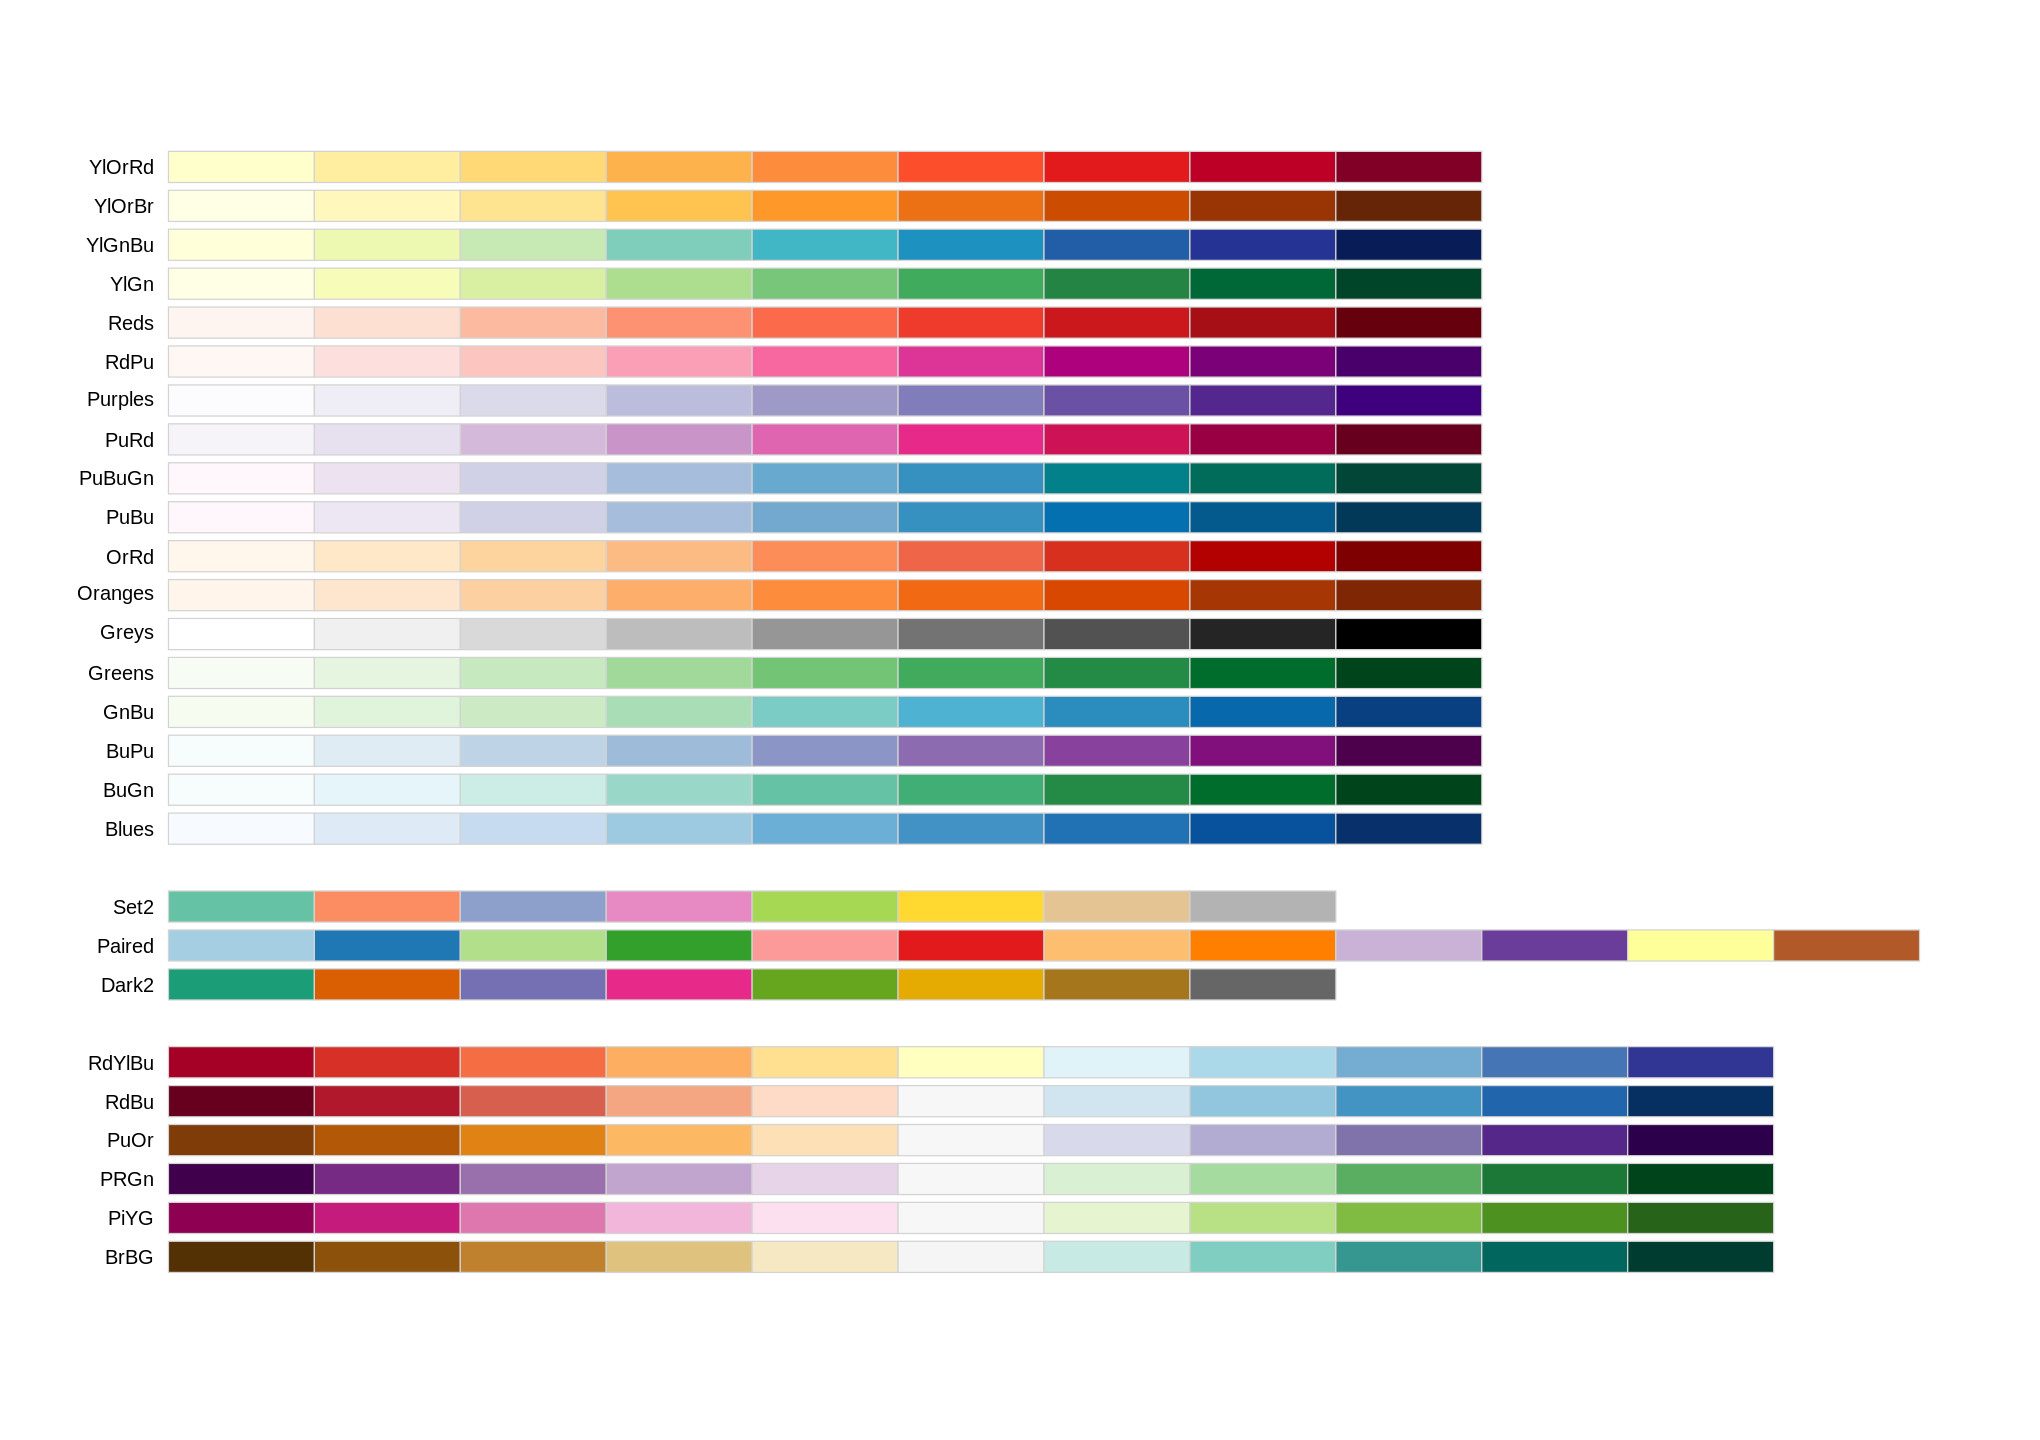

In [131]:
options(repr.plot.width=17, repr.plot.height=12)

# checking colour options to ensure colour blind friendliness of the plots
display.brewer.all(colorblindFriendly = TRUE)

In [ ]:
#  Using only training data, compares the distributions of each of the predictor variables

#Plot 1: Angular Velocity vs. Acceleration of a Body on Dimension X
accl_gyro_x <- training_subset %>%
  ggplot(aes(x = tBodyAcc_mean_X, y = tBodyGyro_mean_X, color = activity_label)) +
  ggtitle("Angular Velocity vs. Acceleration of a Body on Dimension X") +
  geom_point(alpha = 0.4) +
  labs(x = "Acceleration (m/s^2)", y = "Angular Velocity (radians/sec)", color = "Activity Type") +
  scale_color_brewer(palette = "Set2") +
  scale_color_discrete(labels = c("1- Walking", "2- Walking Upstairs", "3- Walking Downstairs", "4- Sitting", "5- Standing", "6- Laying")) +
  theme(text = element_text(size = 18), plot.title = element_text(size=22))

accl_gyro_x

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



In [ ]:
# Plot 2: Angular Velocity vs. Acceleration of a Body on Dimension Y
accl_gyro_y <- training_subset %>%
  ggplot(aes(x = tBodyGyro_mean_Y, y = tBodyAcc_mean_Y, color = activity_label)) +
  ggtitle("Angular Velocity vs. Acceleration of a Body on Dimension Y") +
  geom_point(alpha = 0.4) +
  labs(x = "Acceleration (m/s^2)", y = "Angular Velocity (radians/sec)", color = "Activity Type") +
  scale_color_brewer(palette = "Set2") +
  scale_color_discrete(labels = c("1- Walking", "2- Walking Upstairs", "3- Walking Downstairs", "4- Sitting", "5- Standing", "6- Laying")) +
  theme(text = element_text(size = 18), plot.title = element_text(size=22))

accl_gyro_y

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



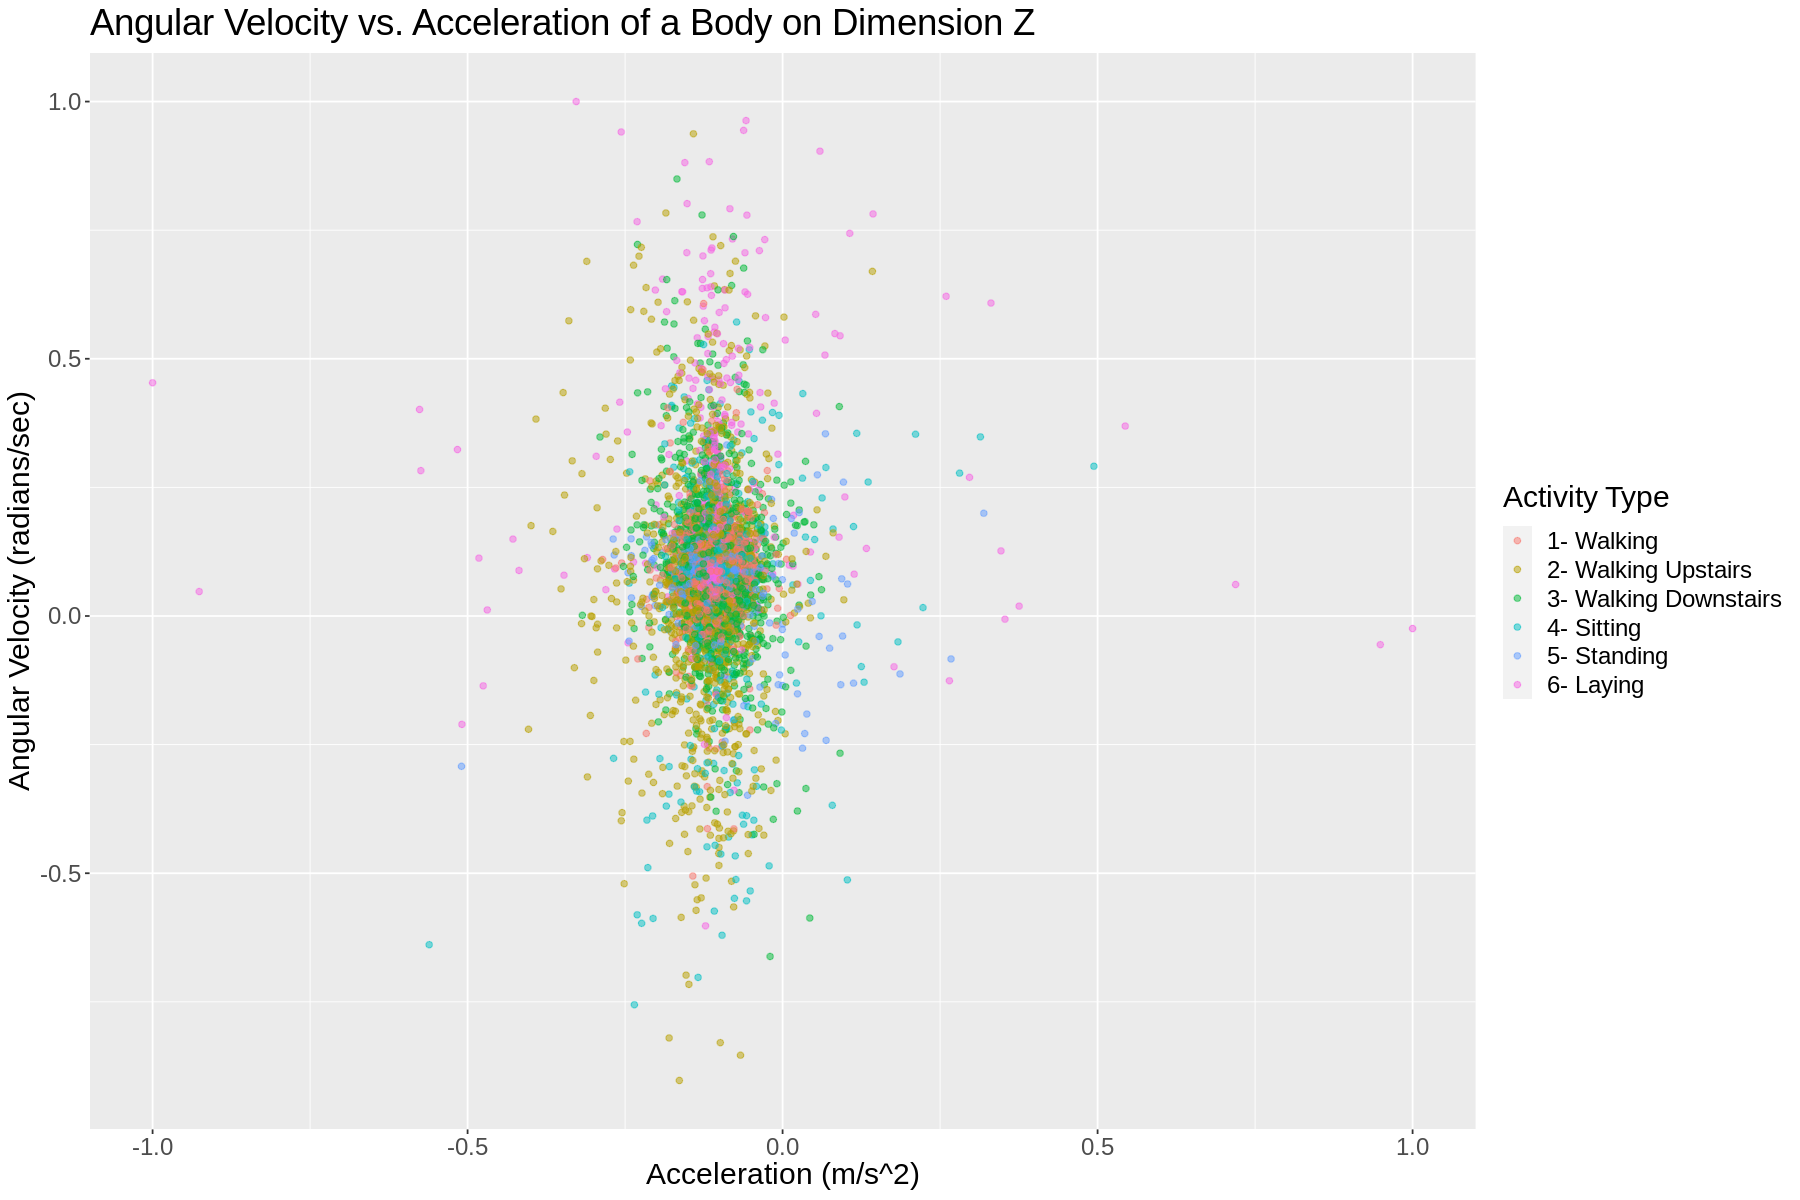

In [130]:
# Plot 3: Angular Velocity vs. Acceleration of a Body on Dimension Z
accl_gyro_z <- training_subset %>%
  ggplot(aes(x = tBodyAcc_mean_Z, y = tBodyGyro_mean_Z, color = activity_label)) +
  ggtitle("Angular Velocity vs. Acceleration of a Body on Dimension Z") +
  geom_point(alpha = 0.5) +
  labs(x = "Acceleration (m/s^2)", y = "Angular Velocity (radians/sec)", color = "Activity Type") +
  scale_color_brewer(palette = "Set2") +
  scale_color_discrete(labels = c("1- Walking", "2- Walking Upstairs", "3- Walking Downstairs", "4- Sitting", "5- Standing", "6- Laying")) +
  theme(text = element_text(size = 18), plot.title = element_text(size=22))

accl_gyro_z

### Expected Outcomes and Significance 

Overall, our project is going to find a corresponding body acceleration and angular velocity for each activity, with the expectation of a harder classification process for static activities and easier classification process for the dynamic motions. Such a finding could make full use of smartphone sensors to have a wider application and also make this technology more mature. Some factors including the smartphone position around the body and the age of the subject may also affect the experiment results; these factors should be considered and the patterns of more dynamic motions such as dancing and running could be studied in the future research.


### Works Cited

Ahmed, Nadeem, Jahir I. Rafiq, and Md R. Islam. "Enhanced Human Activity Recognition Based on Smartphone Sensor Data using Hybrid Feature Selection Model." Sensors, vol. 20, no. 1, 2020, pp. 317.

Anguita, Davide, et al. A Public Domain Dataset for Human Activity Recognition using Smartphones, 2013.

Foerster, Friedrich, Manfred Smeja, and Jochen Fahrenberg. "Detection of Posture and Motion by Accelerometry: A Validation Study in Ambulatory Monitoring." Computers in Human Behavior, vol. 15, no. 5, 1999, pp. 571-583.